<a href="https://colab.research.google.com/github/jglasgo2/BUS60095/blob/main/BUS60095_FinalAssignment_Glasgow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Analysis and Natural Language Processing

Final Assignment

Jeremy Glasgow

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**1. Data Acquisition**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
pathToCsv = '/content/drive/MyDrive/car_reviews_large.csv'
data = pd.read_csv(pathToCsv)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110121 entries, 0 to 110120
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   reviewid           110121 non-null  int64  
 1   make               110121 non-null  object 
 2   model              110121 non-null  object 
 3   year               110121 non-null  int64  
 4   title              110111 non-null  object 
 5   author             110109 non-null  object 
 6   perform_rating     110121 non-null  int64  
 7   comfort_rating     110121 non-null  int64  
 8   fuel_econ_rating   110121 non-null  int64  
 9   fun_rating         110121 non-null  int64  
 10  interior_rating    110121 non-null  int64  
 11  exterior_rating    110121 non-null  int64  
 12  build_qual_rating  110121 non-null  int64  
 13  reliab_rating      110121 non-null  int64  
 14  text               108671 non-null  object 
 15  fav_feat           84292 non-null   object 
 16  su

In [4]:
data.head()

,reviewid,make,model,year,title,author,perform_rating,comfort_rating,fuel_econ_rating,fun_rating,...,exterior_rating,build_qual_rating,reliab_rating,text,fav_feat,sugg_imp,cnt_thumbs_down,cnt_thumbs_up,comment_cnt,Avg_MSRP
0,1,ACURA,ILX,2017,A new Dud,Laurel Blue,0,0,0,0,...,0,0,0,I just leased a new 2017 Acura ILX two months ...,NaN,NaN,0,0,0.0,31203.33333
1,2,ACURA,ILX,2015,Noisy as heck !,Seth L,0,0,0,0,...,0,0,0,"Transmission hums all the time. Acura claims, ...",NaN,NaN,1,2,0.0,29375.00000
2,3,ACURA,ILX,2015,Great entry level luxury car,NicBran,0,0,0,0,...,0,0,0,"Before purchasing this car, I had a Mazda RX-8...",NaN,NaN,0,5,0.0,29375.00000
3,4,ACURA,ILX,2015,Amazing Car!,robin707,5,5,4,5,...,5,5,5,I just purchased the 2015 ILX 2.4 6 speed manu...,"Interior is amazing and so comfortable, the tr...","I'm not sure, maybe GPS and a little bit bette...",0,3,0.0,29375.00000
4,5,ACURA,ILX,2015,My ILX is a great car,stevenrose,5,5,5,5,...,5,5,5,I really enjoy owning my ILX. The ILX offers ...,Why is the ILX not just a Civic EX-L?\r\r\r\n\...,Road noise and the suspension can be a bit sti...,0,18,0.0,29375.00000


Exploring engagement metric features

In [5]:
print(f'Total thumbs up: {data["cnt_thumbs_up"].sum()}')
print(f'Total thumbs down: {data["cnt_thumbs_down"].sum()}')
print(f'Total comments: {data["comment_cnt"].sum()}')

Total thumbs up: 4305592
Total thumbs down: 6812325
Total comments: 13174.0


In [6]:
print(f'Ratio of thumbs up to thumbs down: {(data["cnt_thumbs_up"].sum() / data["cnt_thumbs_down"].sum())}')
print(f'Ratio of thumbs up to comment count: {(data["cnt_thumbs_up"].sum() / data["comment_cnt"].sum())}')
print(f'Ratio of thumbs down to comment count: {(data["cnt_thumbs_down"].sum() / data["comment_cnt"].sum())}')

Ratio of thumbs up to thumbs down: 0.6320297402135101
Ratio of thumbs up to comment count: 326.82495825110067
Ratio of thumbs down to comment count: 517.1037649916502


Visualize distribution of engagement features

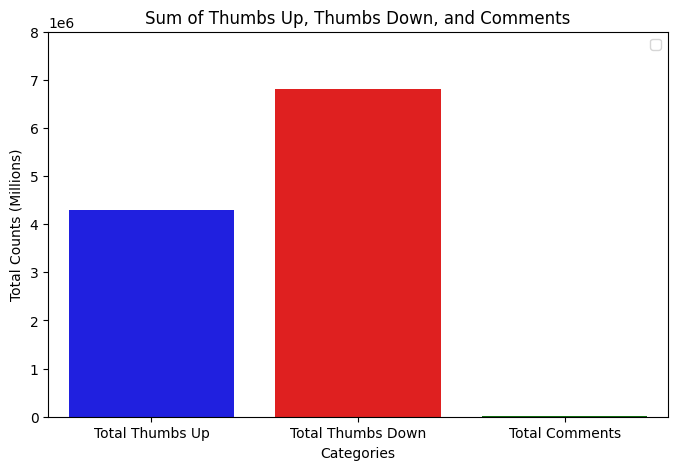

In [7]:
_sums = {
    'Total Thumbs Up': data["cnt_thumbs_up"].sum(),
    'Total Thumbs Down': data["cnt_thumbs_down"].sum(),
    'Total Comments': data["comment_cnt"].sum()
}

sums_df = pd.DataFrame(list(_sums.items()), columns=['Category', 'Total'])

plt.figure(figsize=(8, 5))
sns.barplot(x='Category', y='Total', data=sums_df, palette=['blue', 'red', 'green'])
plt.xlabel('Categories')
plt.ylabel('Total Counts (Millions)')
plt.ylim(0, 8000000)
plt.title('Sum of Thumbs Up, Thumbs Down, and Comments')
plt.legend(loc='upper right')
plt.show()

**2. Text Preprocessing**

View missing values in columns

In [12]:
for column in data.columns:
  print(column, data[column].isna().sum())

reviewid 0
make 0
model 0
year 0
title 10
author 12
perform_rating 0
comfort_rating 0
fuel_econ_rating 0
fun_rating 0
interior_rating 0
exterior_rating 0
build_qual_rating 0
reliab_rating 0
text 1450
fav_feat 25829
sugg_imp 27407
cnt_thumbs_down 0
cnt_thumbs_up 0
comment_cnt 266
Avg_MSRP 0


In [13]:
data["text"].head(10)

0    I just leased a new 2017 Acura ILX two months ...
1    Transmission hums all the time. Acura claims, ...
2    Before purchasing this car, I had a Mazda RX-8...
3    I just purchased the 2015 ILX 2.4 6 speed manu...
4    I really enjoy owning my ILX.  The ILX offers ...
5    My family has had a few acuras. We have always...
6    The more I drive this car, the more I love it....
7    Disappointing with time.  This vehicle doesn't...
8    When I started looking at this car, I found it...
9    I bought my 2014 ILX 2.4 a little over a month...
Name: text, dtype: object

Tokenize

In [14]:
stop_words = set(stopwords.words("english"))

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

data["text"] = data["text"].astype(str)
data["tokens"] = data["text"].apply(tokenize)

In [15]:
data["tokens"].head(10)

0    [I, leased, new, Acura, ILX, two, months, ago,...
1    [Transmission, hums, time, Acura, claims, norm...
2    [Before, purchasing, car, I, Mazda, I, owned, ...
3    [I, purchased, ILX, speed, manual, must, say, ...
4    [I, really, enjoy, owning, ILX, The, ILX, offe...
5    [My, family, acuras, We, always, loved, From, ...
6    [The, I, drive, car, I, love, Like, many, othe...
7    [Disappointing, time, This, vehicle, feel, lik...
8    [When, I, started, looking, car, I, found, med...
9    [I, bought, ILX, little, month, ago, great, pu...
Name: tokens, dtype: object

Stemming

In [16]:
stemmer = SnowballStemmer("english")
data['tokens'] = data['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

In [17]:
data["tokens"].head(10)

0    [i, leas, new, acura, ilx, two, month, ago, th...
1    [transmiss, hum, time, acura, claim, normal, c...
2    [befor, purchas, car, i, mazda, i, own, year, ...
3    [i, purchas, ilx, speed, manual, must, say, fu...
4    [i, realli, enjoy, own, ilx, the, ilx, offer, ...
5    [my, famili, acura, we, alway, love, from, mdx...
6    [the, i, drive, car, i, love, like, mani, othe...
7    [disappoint, time, this, vehicl, feel, like, c...
8    [when, i, start, look, car, i, found, mediocr,...
9    [i, bought, ilx, littl, month, ago, great, pur...
Name: tokens, dtype: object

**3. Text Analysis**

In [18]:
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
data["clean_text"] = data["tokens"].apply(lambda x: " ".join(x))

Using textblob to get a sentiment score

In [20]:
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

data['sentiment_textblob'] = data['clean_text'].apply(get_textblob_sentiment)

In [21]:
data["sentiment_textblob"].describe()

count    110121.000000
mean          0.225784
std           0.197224
min          -1.000000
25%           0.100000
50%           0.224242
75%           0.344444
max           1.000000
Name: sentiment_textblob, dtype: float64

Using SentimentIntensityAnalyzer to get an additional sentiment score

In [22]:
sid = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

data['sentiment_vader'] = data['clean_text'].apply(get_vader_sentiment)

In [23]:
data["sentiment_vader"].describe()

count    110121.000000
mean          0.566331
std           0.531935
min          -0.998600
25%           0.390600
50%           0.827100
75%           0.933700
max           0.999700
Name: sentiment_vader, dtype: float64

**4. Feature Analysis and Feature Selection**

In [24]:
numFeatures = []
catFeatures = []
ratingFeatures = []

for col in data.columns:
  if data[col].dtype == "object":
    catFeatures.append(col)
  else:
    numFeatures.append(col)
  if "rating" in col:
    ratingFeatures.append(col)

print(f"Numerical Features: {numFeatures}")
print(f"Categorical Features: {catFeatures}")
print(f"Rating Features: {ratingFeatures}")

Numerical Features: ['reviewid', 'year', 'perform_rating', 'comfort_rating', 'fuel_econ_rating', 'fun_rating', 'interior_rating', 'exterior_rating', 'build_qual_rating', 'reliab_rating', 'cnt_thumbs_down', 'cnt_thumbs_up', 'comment_cnt', 'Avg_MSRP', 'sentiment_textblob', 'sentiment_vader']
Categorical Features: ['make', 'model', 'title', 'author', 'text', 'fav_feat', 'sugg_imp', 'tokens', 'clean_text']
Rating Features: ['perform_rating', 'comfort_rating', 'fuel_econ_rating', 'fun_rating', 'interior_rating', 'exterior_rating', 'build_qual_rating', 'reliab_rating']


In [25]:
data[numFeatures].describe()

,reviewid,year,perform_rating,comfort_rating,fuel_econ_rating,fun_rating,interior_rating,exterior_rating,build_qual_rating,reliab_rating,cnt_thumbs_down,cnt_thumbs_up,comment_cnt,Avg_MSRP,sentiment_textblob,sentiment_vader
count,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,109855.000000,1.101210e+05,110121.000000,110121.000000
mean,55061.000000,2009.810999,3.695117,3.745725,3.438708,3.734637,3.721879,3.872976,3.651202,3.717974,61.862179,39.098737,0.119922,3.022002e+04,0.225784,0.566331
std,31789.338834,2.794950,1.849023,1.835550,1.801905,1.869711,1.835980,1.835164,1.917184,1.936384,3197.293935,2517.929156,0.687758,2.056580e+04,0.197224,0.531935
min,1.000000,2007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.184375e+04,-1.000000,-0.998600
25%,27531.000000,2008.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000,0.000000,0.000000,0.000000,2.259500e+04,0.100000,0.390600
50%,55061.000000,2009.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,0.000000,0.000000,2.684750e+04,0.224242,0.827100
75%,82591.000000,2011.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000,3.000000,0.000000,3.456167e+04,0.344444,0.933700
max,110121.000000,2017.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,183876.000000,183223.000000,55.000000,1.782951e+06,1.000000,0.999700


In [26]:
data[ratingFeatures].describe()

,perform_rating,comfort_rating,fuel_econ_rating,fun_rating,interior_rating,exterior_rating,build_qual_rating,reliab_rating
count,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000,110121.000000
mean,3.695117,3.745725,3.438708,3.734637,3.721879,3.872976,3.651202,3.717974
std,1.849023,1.835550,1.801905,1.869711,1.835980,1.835164,1.917184,1.936384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000
50%,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [27]:
carMake = data.groupby("make")[ratingFeatures].mean()
carMake_sorted = carMake.sort_values(by=ratingFeatures, ascending=False)
carMake_sorted

,perform_rating,comfort_rating,fuel_econ_rating,fun_rating,interior_rating,exterior_rating,build_qual_rating,reliab_rating
make,,,,,,,,
SPYKER,5.000000,5.000000,4.000000,4.333333,4.666667,4.333333,4.666667,4.333333
BUGATTI,5.000000,4.375000,2.625000,5.000000,4.625000,5.000000,4.875000,4.625000
LOTUS,5.000000,3.333333,4.333333,4.833333,3.916667,4.833333,4.000000,4.333333
MAYBACH,4.500000,5.000000,4.500000,4.500000,5.000000,4.500000,5.000000,4.000000
LAMBORGHINI,4.500000,4.166667,3.333333,4.333333,4.083333,4.500000,4.416667,4.166667
PONTIAC,4.480174,4.430744,4.060837,4.557849,4.321021,4.617056,4.343292,4.462792
ASTON-MARTIN,4.470588,4.294118,2.764706,4.588235,4.352941,4.705882,4.000000,3.882353
MERCURY,4.344872,4.497436,4.105128,4.371795,4.402564,4.489744,4.376923,4.462821
SAAB,4.326087,4.434783,3.130435,4.260870,4.239130,4.369565,4.304348,4.391304


In [30]:
carYear = data.groupby("year")[ratingFeatures].mean()
carYear_sorted = carYear.sort_values(by=ratingFeatures, ascending=False)
carYear_sorted

,perform_rating,comfort_rating,fuel_econ_rating,fun_rating,interior_rating,exterior_rating,build_qual_rating,reliab_rating
year,,,,,,,,
2007,4.344576,4.390021,3.935254,4.400000,4.345040,4.527248,4.272868,4.349758
2008,4.312184,4.352781,3.916338,4.368708,4.332655,4.495867,4.250941,4.326033
2009,4.273743,4.290405,4.007984,4.313871,4.282630,4.466815,4.232852,4.315746
2010,4.235721,4.307133,3.979287,4.272741,4.282711,4.428240,4.238658,4.311461
2011,3.820261,3.935594,3.701661,3.865468,3.903050,4.067810,3.773284,3.830202
2012,3.396162,3.481212,3.395960,3.429899,3.458384,3.630303,3.396566,3.484646
2013,3.169127,3.283312,3.126145,3.176789,3.267053,3.411325,3.109512,3.161839
2014,2.652355,2.728301,2.599492,2.657202,2.710526,2.855956,2.587027,2.645429
2015,1.049393,1.068327,1.043836,1.048570,1.057831,1.088496,1.035398,1.056596


Collect linear coefficients

In [36]:
data["text"] = data["text"].astype(str)
data["textlen"] = data["text"].apply(len)

In [191]:
from sklearn.linear_model import LinearRegression

predictors = ratingFeatures + ["textlen"] + ["sentiment_textblob", "sentiment_vader"]
_x = data[predictors]
_y = data["cnt_thumbs_up"]

model = LinearRegression().fit(_x, _y)

coefficients = pd.Series(model.coef_, index=predictors)
pd.Series(coefficients, index=predictors).sort_values()

sentiment_textblob   -44.849020
fun_rating           -18.900583
perform_rating        -9.268518
interior_rating       -4.430156
textlen                0.012689
fuel_econ_rating       1.952006
reliab_rating          3.282221
comfort_rating         3.930651
exterior_rating       11.003790
sentiment_vader       18.449820
build_qual_rating     20.839968
dtype: float64

In [192]:
data["total_thumbs_cnt"] = data["cnt_thumbs_up"] + data["cnt_thumbs_down"]

predictors = ratingFeatures + ["textlen"] + ["sentiment_textblob", "sentiment_vader"]
_x = data[predictors]
_y = data["total_thumbs_cnt"]

model = LinearRegression().fit(_x, _y)

coefficients = pd.Series(model.coef_, index=predictors)
pd.Series(coefficients, index=predictors).sort_values()

sentiment_textblob   -59.274871
fun_rating           -54.747488
reliab_rating        -11.116127
interior_rating       -3.840684
textlen                0.077612
comfort_rating         7.846858
perform_rating        15.849384
fuel_econ_rating      19.225071
exterior_rating       22.011211
build_qual_rating     31.480302
sentiment_vader       35.096818
dtype: float64

In [193]:
data["cnt_thumbs_up"] = data["cnt_thumbs_up"] + 1
data["cnt_thumbs_down"] = data["cnt_thumbs_down"] + 1
data["thumbs_up_pct"] = data["cnt_thumbs_up"]  / (data["cnt_thumbs_down"] + data["cnt_thumbs_up"])
data["thumbs_up_pct"].describe()

count    110121.000000
mean          0.564844
std           0.136421
min           0.000011
25%           0.500000
50%           0.500000
75%           0.666667
max           0.999989
Name: thumbs_up_pct, dtype: float64

In [194]:
predictors = ratingFeatures + ["textlen"] + ["sentiment_textblob", "sentiment_vader"]
_x = data[predictors]
_y = data["thumbs_up_pct"]

model = LinearRegression().fit(_x, _y)

coefficients = pd.Series(model.coef_, index=predictors)
pd.Series(coefficients, index=predictors).sort_values()

reliab_rating        -0.011233
exterior_rating      -0.009080
perform_rating       -0.004374
textlen               0.000077
sentiment_textblob    0.000359
interior_rating       0.000513
fun_rating            0.001764
comfort_rating        0.002058
build_qual_rating     0.003598
fuel_econ_rating      0.011050
sentiment_vader       0.015749
dtype: float64

**5. Model Testing and Model Building**

In [147]:
randomNum = 13

In [148]:
xTrain, xTemp, yTrain, yTemp = train_test_split(data[predictors], data["thumbs_up_pct"], test_size=0.3, random_state=randomNum)
xVal, xTest, yVal, yTest = train_test_split(xTemp, yTemp, test_size=0.33, random_state=randomNum)

In [149]:
print(f"xTrain: {xTrain.shape}")
print(f"xVal: {xVal.shape}")
print(f"xTest: {xTest.shape}")
print(f"yTrain: {yTrain.shape}")
print(f"yVal: {yVal.shape}")
print(f"yTest: {yTest.shape}")

xTrain: (77084, 11)
xVal: (22134, 11)
xTest: (10903, 11)
yTrain: (77084,)
yVal: (22134,)
yTest: (10903,)


In [150]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xVal_scaled = scaler.transform(xVal)
xTest_scaled = scaler.transform(xTest)

In [151]:
from sklearn.metrics import mean_absolute_error

baseline_prediction = np.mean(yTrain)
y_pred_baseline = np.full_like(yTest, baseline_prediction)
baseline_mae = mean_absolute_error(yTest, y_pred_baseline)

print(f'Baseline Mean Absolute Error (MAE): {baseline_mae}')

Baseline Mean Absolute Error (MAE): 0.1395926735142647


In [152]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(len(predictors), )),
    Dense(32, activation='relu'),
    Dense(1)
])

In [153]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

history = model.fit(xTrain_scaled, yTrain, epochs=30, batch_size=256, validation_data=(xVal_scaled, yVal), verbose=1)

Epoch 1/30
302/302 [==============================] - 2s 4ms/step - loss: 0.0392 - mean_absolute_error: 0.1491 - val_loss: 0.0274 - val_mean_absolute_error: 0.1279
Epoch 2/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0262 - mean_absolute_error: 0.1268 - val_loss: 0.0260 - val_mean_absolute_error: 0.1267
Epoch 3/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0255 - mean_absolute_error: 0.1257 - val_loss: 0.0261 - val_mean_absolute_error: 0.1282
Epoch 4/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0254 - mean_absolute_error: 0.1256 - val_loss: 0.0256 - val_mean_absolute_error: 0.1282
Epoch 5/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0253 - mean_absolute_error: 0.1254 - val_loss: 0.0254 - val_mean_absolute_error: 0.1254
Epoch 6/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0251 - mean_absolute_error: 0.1252 - val_loss: 0.0254 - val_mean_absolute_error: 0.1257
Epoch 7/30
302/3

In [154]:
y_pred = model.predict(xTest_scaled)
test_mae = mean_absolute_error(yTest, y_pred)
print(f'Test MAE: {test_mae}')

341/341 [==============================] - 0s 1ms/step
Test MAE: 0.13118057894787544


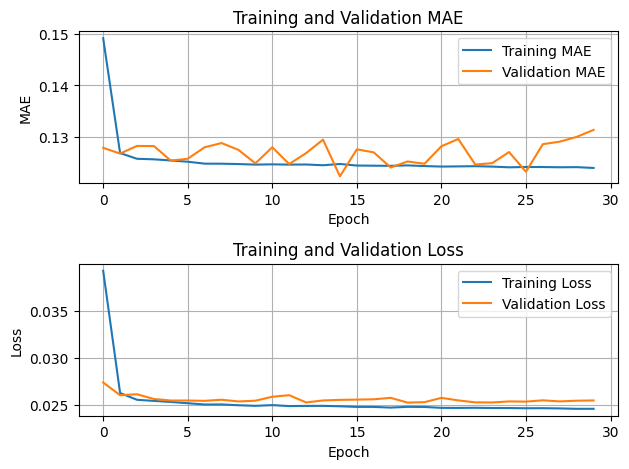

In [155]:
plt.subplot(2, 1, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [156]:
predictors = ratingFeatures

In [157]:
xTrain, xTemp, yTrain, yTemp = train_test_split(data[predictors], data["thumbs_up_pct"], test_size=0.3, random_state=randomNum)
xVal, xTest, yVal, yTest = train_test_split(xTemp, yTemp, test_size=0.33, random_state=randomNum)

In [158]:
print(f"xTrain: {xTrain.shape}")
print(f"xVal: {xVal.shape}")
print(f"xTest: {xTest.shape}")
print(f"yTrain: {yTrain.shape}")
print(f"yVal: {yVal.shape}")
print(f"yTest: {yTest.shape}")

xTrain: (77084, 8)
xVal: (22134, 8)
xTest: (10903, 8)
yTrain: (77084,)
yVal: (22134,)
yTest: (10903,)


In [159]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xVal_scaled = scaler.transform(xVal)
xTest_scaled = scaler.transform(xTest)

In [160]:
from sklearn.metrics import mean_absolute_error

baseline_prediction = np.mean(yTrain)
y_pred_baseline = np.full_like(yTest, baseline_prediction)
baseline_mae = mean_absolute_error(yTest, y_pred_baseline)

print(f'Baseline Mean Absolute Error (MAE): {baseline_mae}')

Baseline Mean Absolute Error (MAE): 0.1395926735142647


In [161]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(len(predictors), )),
    Dense(32, activation='relu'),
    Dense(1)
])

In [162]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

history = model.fit(xTrain_scaled, yTrain, epochs=30, batch_size=256, validation_data=(xVal_scaled, yVal), verbose=1)

Epoch 1/30
302/302 [==============================] - 2s 4ms/step - loss: 0.0413 - mean_absolute_error: 0.1550 - val_loss: 0.0290 - val_mean_absolute_error: 0.1340
Epoch 2/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0280 - mean_absolute_error: 0.1332 - val_loss: 0.0288 - val_mean_absolute_error: 0.1347
Epoch 3/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0276 - mean_absolute_error: 0.1327 - val_loss: 0.0287 - val_mean_absolute_error: 0.1341
Epoch 4/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0274 - mean_absolute_error: 0.1323 - val_loss: 0.0279 - val_mean_absolute_error: 0.1365
Epoch 5/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0274 - mean_absolute_error: 0.1324 - val_loss: 0.0290 - val_mean_absolute_error: 0.1373
Epoch 6/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0273 - mean_absolute_error: 0.1322 - val_loss: 0.0278 - val_mean_absolute_error: 0.1314
Epoch 7/30
302/3

In [163]:
y_pred = model.predict(xTest_scaled)
test_mae = mean_absolute_error(yTest, y_pred)
print(f'Test MAE: {test_mae}')

341/341 [==============================] - 1s 1ms/step
Test MAE: 0.13195533887901412


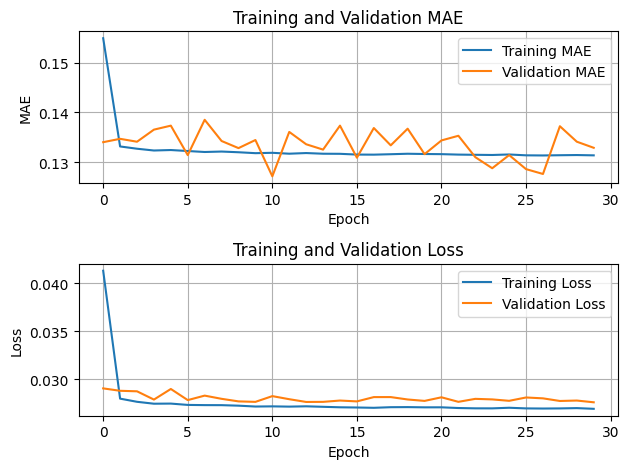

In [164]:
plt.subplot(2, 1, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [165]:
predictors = ["sentiment_textblob", "sentiment_vader"]

In [166]:
xTrain, xTemp, yTrain, yTemp = train_test_split(data[predictors], data["thumbs_up_pct"], test_size=0.3, random_state=randomNum)
xVal, xTest, yVal, yTest = train_test_split(xTemp, yTemp, test_size=0.33, random_state=randomNum)

In [167]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xVal_scaled = scaler.transform(xVal)
xTest_scaled = scaler.transform(xTest)

In [168]:
from sklearn.metrics import mean_absolute_error

baseline_prediction = np.mean(yTrain)
y_pred_baseline = np.full_like(yTest, baseline_prediction)
baseline_mae = mean_absolute_error(yTest, y_pred_baseline)

print(f'Baseline Mean Absolute Error (MAE): {baseline_mae}')

Baseline Mean Absolute Error (MAE): 0.1395926735142647


In [169]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(len(predictors), )),
    Dense(32, activation='relu'),
    Dense(1)
])

In [170]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

history = model.fit(xTrain_scaled, yTrain, epochs=30, batch_size=256, validation_data=(xVal_scaled, yVal), verbose=1)

Epoch 1/30
302/302 [==============================] - 2s 4ms/step - loss: 0.0362 - mean_absolute_error: 0.1504 - val_loss: 0.0285 - val_mean_absolute_error: 0.1382
Epoch 2/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0280 - mean_absolute_error: 0.1374 - val_loss: 0.0287 - val_mean_absolute_error: 0.1406
Epoch 3/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0279 - mean_absolute_error: 0.1372 - val_loss: 0.0283 - val_mean_absolute_error: 0.1409
Epoch 4/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0279 - mean_absolute_error: 0.1373 - val_loss: 0.0293 - val_mean_absolute_error: 0.1424
Epoch 5/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0278 - mean_absolute_error: 0.1371 - val_loss: 0.0282 - val_mean_absolute_error: 0.1381
Epoch 6/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0278 - mean_absolute_error: 0.1371 - val_loss: 0.0283 - val_mean_absolute_error: 0.1401
Epoch 7/30
302/3

In [171]:
y_pred = model.predict(xTest_scaled)
test_mae = mean_absolute_error(yTest, y_pred)
print(f'Test MAE: {test_mae}')

341/341 [==============================] - 0s 1ms/step
Test MAE: 0.13464674825492975


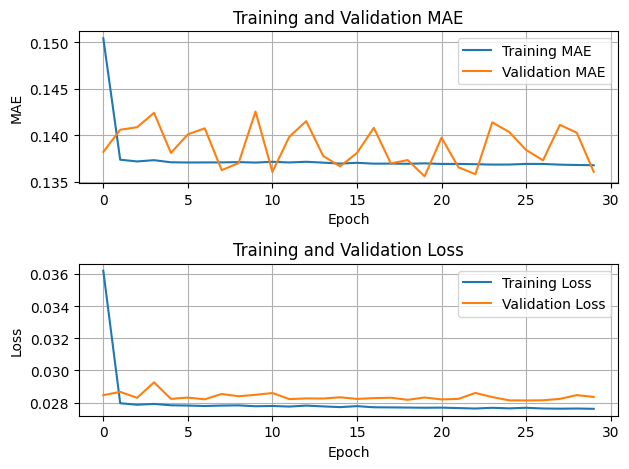

In [172]:
plt.subplot(2, 1, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [173]:
predictors = ratingFeatures + ["sentiment_vader"]

In [174]:
xTrain, xTemp, yTrain, yTemp = train_test_split(data[predictors], data["thumbs_up_pct"], test_size=0.3, random_state=randomNum)
xVal, xTest, yVal, yTest = train_test_split(xTemp, yTemp, test_size=0.33, random_state=randomNum)

In [175]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xVal_scaled = scaler.transform(xVal)
xTest_scaled = scaler.transform(xTest)

In [177]:
from sklearn.metrics import mean_absolute_error

baseline_prediction = np.mean(yTrain)
y_pred_baseline = np.full_like(yTest, baseline_prediction)
baseline_mae = mean_absolute_error(yTest, y_pred_baseline)

print(f'Baseline Mean Absolute Error (MAE): {baseline_mae}')

Baseline Mean Absolute Error (MAE): 0.1395926735142647


In [178]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(len(predictors), )),
    Dense(32, activation='relu'),
    Dense(1)
])

In [179]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

history = model.fit(xTrain_scaled, yTrain, epochs=30, batch_size=256, validation_data=(xVal_scaled, yVal), verbose=1)

Epoch 1/30
302/302 [==============================] - 2s 4ms/step - loss: 0.0344 - mean_absolute_error: 0.1443 - val_loss: 0.0279 - val_mean_absolute_error: 0.1332
Epoch 2/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0273 - mean_absolute_error: 0.1312 - val_loss: 0.0278 - val_mean_absolute_error: 0.1297
Epoch 3/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0269 - mean_absolute_error: 0.1306 - val_loss: 0.0271 - val_mean_absolute_error: 0.1329
Epoch 4/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0266 - mean_absolute_error: 0.1301 - val_loss: 0.0270 - val_mean_absolute_error: 0.1318
Epoch 5/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0265 - mean_absolute_error: 0.1297 - val_loss: 0.0273 - val_mean_absolute_error: 0.1325
Epoch 6/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0265 - mean_absolute_error: 0.1298 - val_loss: 0.0271 - val_mean_absolute_error: 0.1280
Epoch 7/30
302/3

In [180]:
test_loss, test_mae = model.evaluate(xTest_scaled, yTest)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

341/341 [==============================] - 1s 2ms/step - loss: 0.0273 - mean_absolute_error: 0.1357
Test Loss: 0.02733563631772995
Test MAE: 0.13571640849113464


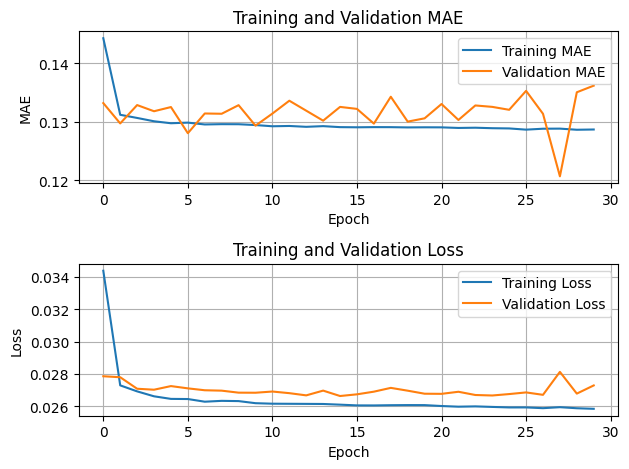

In [181]:
plt.subplot(2, 1, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [182]:
predictors = ratingFeatures + ["sentiment_textblob"]

In [183]:
xTrain, xTemp, yTrain, yTemp = train_test_split(data[predictors], data["thumbs_up_pct"], test_size=0.3, random_state=randomNum)
xVal, xTest, yVal, yTest = train_test_split(xTemp, yTemp, test_size=0.33, random_state=randomNum)

In [184]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xVal_scaled = scaler.transform(xVal)
xTest_scaled = scaler.transform(xTest)

In [185]:
from sklearn.metrics import mean_absolute_error

baseline_prediction = np.mean(yTrain)
y_pred_baseline = np.full_like(yTest, baseline_prediction)
baseline_mae = mean_absolute_error(yTest, y_pred_baseline)

print(f'Baseline Mean Absolute Error (MAE): {baseline_mae}')

Baseline Mean Absolute Error (MAE): 0.1395926735142647


In [186]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(len(predictors), )),
    Dense(32, activation='relu'),
    Dense(1)
])

In [188]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

history = model.fit(xTrain_scaled, yTrain, epochs=30, batch_size=256, validation_data=(xVal_scaled, yVal), verbose=1)

Epoch 1/30
302/302 [==============================] - 2s 4ms/step - loss: 0.0436 - mean_absolute_error: 0.1570 - val_loss: 0.0292 - val_mean_absolute_error: 0.1341
Epoch 2/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0279 - mean_absolute_error: 0.1322 - val_loss: 0.0277 - val_mean_absolute_error: 0.1328
Epoch 3/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0271 - mean_absolute_error: 0.1309 - val_loss: 0.0273 - val_mean_absolute_error: 0.1305
Epoch 4/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0270 - mean_absolute_error: 0.1308 - val_loss: 0.0275 - val_mean_absolute_error: 0.1336
Epoch 5/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0268 - mean_absolute_error: 0.1305 - val_loss: 0.0279 - val_mean_absolute_error: 0.1371
Epoch 6/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0267 - mean_absolute_error: 0.1303 - val_loss: 0.0280 - val_mean_absolute_error: 0.1344
Epoch 7/30
302/3

In [189]:
test_loss, test_mae = model.evaluate(xTest_scaled, yTest)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

341/341 [==============================] - 1s 2ms/step - loss: 0.0270 - mean_absolute_error: 0.1296
Test Loss: 0.02695305645465851
Test MAE: 0.1296122670173645


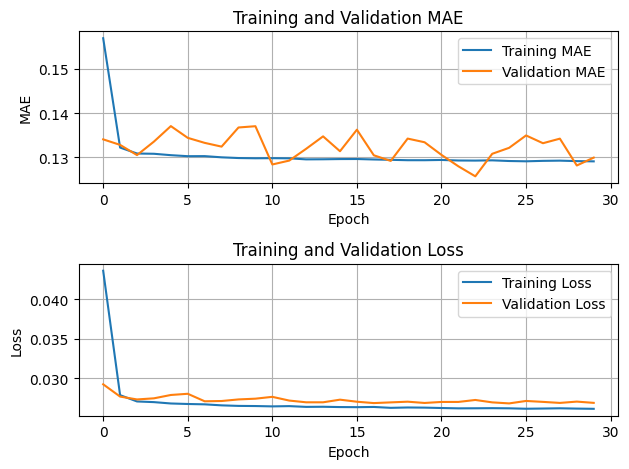

In [190]:
plt.subplot(2, 1, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [195]:
from sklearn.linear_model import Lasso
predictors = ratingFeatures + ["sentiment_textblob", "sentiment_vader"]

xTrain, xTemp, yTrain, yTemp = train_test_split(data[predictors], data["thumbs_up_pct"], test_size=0.3, random_state=randomNum)
xVal, xTest, yVal, yTest = train_test_split(xTemp, yTemp, test_size=0.33, random_state=randomNum)

In [196]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xVal_scaled = scaler.transform(xVal)
xTest_scaled = scaler.transform(xTest)

In [197]:
from sklearn.metrics import mean_absolute_error

baseline_prediction = np.mean(yTrain)
y_pred_baseline = np.full_like(yTest, baseline_prediction)
baseline_mae = mean_absolute_error(yTest, y_pred_baseline)

print(f'Baseline Mean Absolute Error (MAE): {baseline_mae}')

Baseline Mean Absolute Error (MAE): 0.10729941841937285


In [203]:
_alpha = 0.002

lasso = Lasso(alpha=_alpha)
lasso.fit(xTrain_scaled, yTrain)

coefficients = lasso.coef_
selected_features = np.array(predictors)[coefficients != 0]
print(f'Selected Features: {selected_features}')

Selected Features: ['perform_rating' 'fuel_econ_rating' 'exterior_rating' 'reliab_rating'
 'sentiment_textblob' 'sentiment_vader']


In [204]:
predictors = selected_features

In [205]:
xTrain, xTemp, yTrain, yTemp = train_test_split(data[predictors], data["thumbs_up_pct"], test_size=0.3, random_state=randomNum)
xVal, xTest, yVal, yTest = train_test_split(xTemp, yTemp, test_size=0.33, random_state=randomNum)

In [206]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xVal_scaled = scaler.transform(xVal)
xTest_scaled = scaler.transform(xTest)

In [207]:
from sklearn.metrics import mean_absolute_error

baseline_prediction = np.mean(yTrain)
y_pred_baseline = np.full_like(yTest, baseline_prediction)
baseline_mae = mean_absolute_error(yTest, y_pred_baseline)

print(f'Baseline Mean Absolute Error (MAE): {baseline_mae}')

Baseline Mean Absolute Error (MAE): 0.10729941841937285


In [208]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(len(predictors), )),
    Dense(32, activation='relu'),
    Dense(1)
])

In [209]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

history = model.fit(xTrain_scaled, yTrain, epochs=30, batch_size=256, validation_data=(xVal_scaled, yVal), verbose=1)

Epoch 1/30
302/302 [==============================] - 2s 4ms/step - loss: 0.0343 - mean_absolute_error: 0.1307 - val_loss: 0.0185 - val_mean_absolute_error: 0.1041
Epoch 2/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0178 - mean_absolute_error: 0.1011 - val_loss: 0.0182 - val_mean_absolute_error: 0.0988
Epoch 3/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0174 - mean_absolute_error: 0.1002 - val_loss: 0.0179 - val_mean_absolute_error: 0.1003
Epoch 4/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0173 - mean_absolute_error: 0.0998 - val_loss: 0.0176 - val_mean_absolute_error: 0.1030
Epoch 5/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0172 - mean_absolute_error: 0.0999 - val_loss: 0.0176 - val_mean_absolute_error: 0.1016
Epoch 6/30
302/302 [==============================] - 1s 3ms/step - loss: 0.0172 - mean_absolute_error: 0.0998 - val_loss: 0.0175 - val_mean_absolute_error: 0.1002
Epoch 7/30
302/3

In [210]:
test_loss, test_mae = model.evaluate(xTest_scaled, yTest)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

341/341 [==============================] - 1s 2ms/step - loss: 0.0172 - mean_absolute_error: 0.1009
Test Loss: 0.017182204872369766
Test MAE: 0.10088558495044708


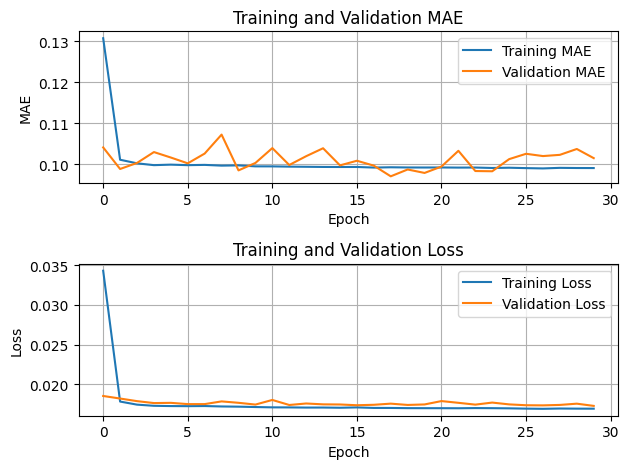

In [211]:
plt.subplot(2, 1, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()